# 1st Trading Project

With the aid of Bagehot's contributions (The Only Game in Town Links to an external site.), and Copeland & Galai's model (Information Effects on the Bid-Ask Spread Links to an external site.) demonstrated how, even without transaction costs, a spread would exist. This led us to maximize the market maker's profit function in terms of a Bid & Ask price.

### Parameters
1. **Stock Price Follows a Lognormal Distribution:**
   $$
   P \sim \text{Lognormal}(60, 2.25)
   $$
   This parameter indicates that the stock price follows a lognormal distribution with a mean of 60 and a variance of $2.25$.

2. **Probability of an Informed Trade:**
   $$
   \Pi_I = 0.4
   $$
   Here, $\Pi_I$ represents the probability that a trade is informed, set at $0.4$ or $40\%$.

3. **Buy Limit Probability ($\Pi_{LB}$) as a Function of $S$:**
   $$
   \Pi_{LB}(S) = 0.5 - 0.08S \quad \text{where} \quad \Pi_{LB} \in [0, 0.5], \quad S = \left(A - S_0\right)
   $$
   This equation defines $\Pi_{LB}$, the probability of a buy limit, as a linear function of $S$, where $S$ is the difference between the proposed stock price $A$ and the initial stock price $S_0$.

4. **Sell Limit Probability ($\Pi_{LS}$) as a Function of $S$:**
   $$
   \Pi_{LS}(S) = 0.5 - 0.08S \quad \text{where} \quad \Pi_{LS} \in [0, 0.5], \quad S = \left(S_0 - B\right)
   $$
   Similar to $\Pi_{LB}$, this equation defines $\Pi_{LS}$, the probability of a sell limit, as a linear function of $S$, where $S$ is the difference between the initial stock price $S_0$ and the bid price $B$.

5. **Initial Stock Price $S_0$:**
   $$
   S_0 = 65
   $$
   Here, $S_0$ is set to 65, indicating the initial stock price before any trades.


Use this wisely:

$$
\begin{aligned}
& \max _{K_A, K_B}\left\{\left(1-p_I\right)\left[p_{B L}\left(K_A-S_0\right)+p_{S L}\left(S_0-K_B\right)\right]\right. \\
&\left.-p_I\left[\int_{K_A}^{\infty}\left(S-K_A\right) f(S) d S+\int_0^{K_B}\left(K_B-S\right) f(S) d S\right]\right\} \geq 0
\end{aligned}
$$

---

In [4]:
from sympy import integrate, init_printing as sp
from sympy.abc import x as xsp
import scipy.stats as st
import scipy.optimize as opt
import tqdm
from scipy.integrate import quad
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

/Users/luisrobles/Desktop/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/luisrobles/Desktop/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


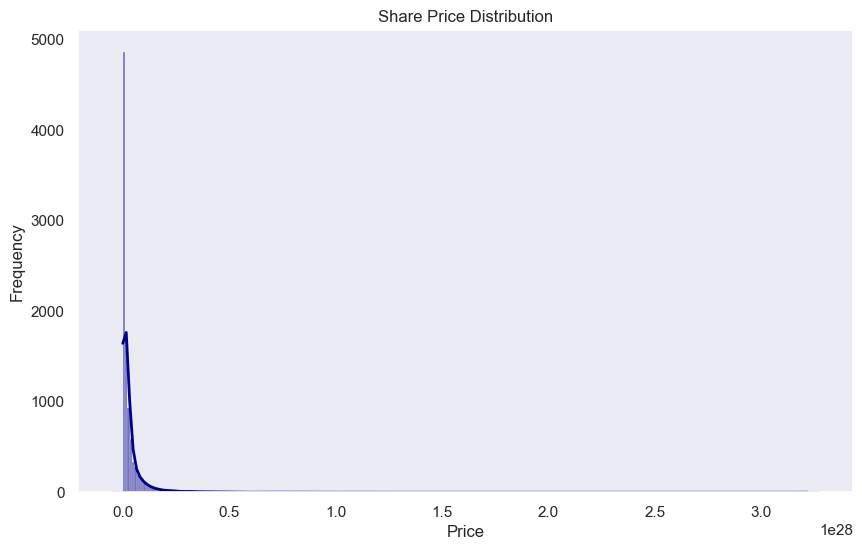

In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Parámetros para la distribución Lognormal
mu = 60
sigma = np.sqrt(2.25)

num_simulations = 10000
prices = np.random.lognormal(mean=mu, sigma=sigma, size=num_simulations)

# Establecer el estilo del gráfico
sns.set(style="dark")

plt.figure(figsize=(10, 6))
sns.histplot(prices, bins=300, kde=True, color='darkblue', fill=True, line_kws={'linewidth': 2})
plt.title('Share Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Añadir línea de densidad de kernel (KDE)
sns.kdeplot(prices, color="navy", linewidth=2, alpha=0.7)

plt.show()


/Users/luisrobles/Desktop/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


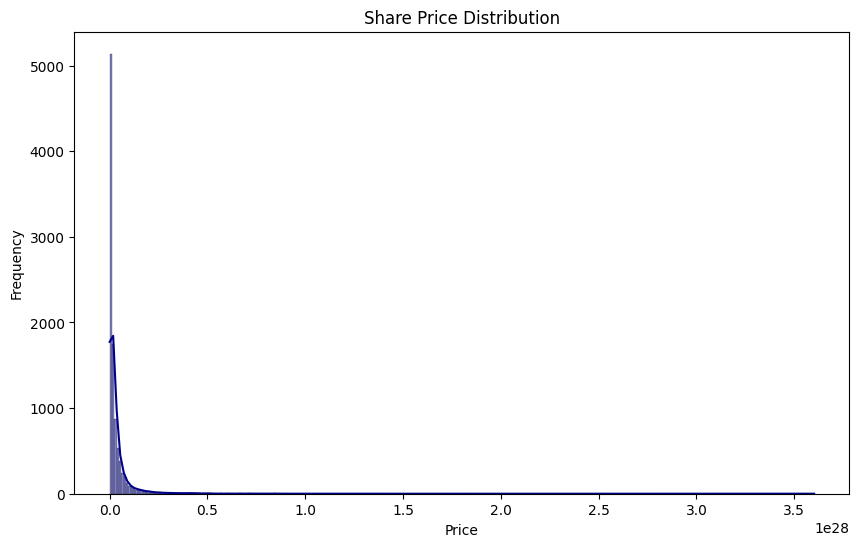

In [7]:
# Parámetros para la distribución Lognormal
mu = 60
sigma = np.sqrt(2.25)

num_simulations = 10000
prices = np.random.lognormal(mean=mu, sigma=sigma, size=num_simulations)

plt.figure(figsize=(10, 6))
sns.histplot(prices, bins=300, kde=True, color='darkblue')
plt.title('Share Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [8]:
np.mean(prices)

3.614588855988686e+26